### Imports

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import matplotlib
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

# To save space in the body of our paper, we're shrinking
# the height of the plots in this notebook.
FIG_HEIGHT_MULTIPLIER = 0.7

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col-neurips"),
        utils.get_style("small-legend"),
        {
            "ytick.minor.visible": True,
            "ytick.left": True,
            "ytick.right": True,
        },
    ]
)
utils.import_plt_sty("defense-macros.sty")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]
TARGET_VISITS = 512


def force_minor_ticks(ax: matplotlib.axes.Axes) -> None:
    """Force minor ticks to show on a plot."""
    # https://stackoverflow.com/a/73094650/1337463
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))

### Helper functions

In [19]:
def filter_df_for_player(df: pd.DataFrame, player_substring: str):
    """Get df rows matching a player substring."""
    return df[
        (df["b_name"].str.contains(player_substring))
        | (df["w_name"].str.contains(player_substring))
    ].copy()


def get_adv_win_grouped_by_victim_visits(
    df: pd.DataFrame,
    # default query returns everything
    df_query: str = "index == index or index != index",
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by victim visits.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("victim_visits")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi


def plot_victim_visit_sweep(
    dfs: list[tuple[pd.DataFrame, str]],
    victim_label: str,
    custom_ylabel: str | None = None,
    custom_xlabel: str = "Victim visits",
    color = None,
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot performance of A-MCTS-{R,S++} vs. varying victim visits.

    Args:
        dfs: Dataframes of games paired with a label for each dataframe.
        victim_label: The label to give the victim on the plot.
    """
    fig, ax = plt.subplots(1, 1)

    for i, (df, label) in enumerate(dfs):
        m, l, h = get_adv_win_grouped_by_victim_visits(df)
        
        # Give common adversaries the same color across all plots for consistency
        color = COLORS[i]
        if "origcyclic" in label:
            color = COLORS[3]
        if "attackbsixty" in label:
            color = COLORS[2]
        m.plot(label=label, color=color)
        ax.fill_between(m.index, l, h, facecolor=color, alpha=0.3)

    plt.ylim(-5, 105)
    plt.xscale("log")
    plt.ylabel(custom_ylabel or f"Win \\% vs. {victim_label}")
    plt.xlabel(custom_xlabel)
    force_minor_ticks(ax)
    utils.filter_x_minor_ticks()
    if len(dfs) > 1:
        plt.legend()

    return fig, ax

In [20]:
def get_visit_games(df: pd.DataFrame, target_visits = TARGET_VISITS) -> pd.DataFrame:
    "Get all games with one player having a particular visit count."
    assert (
        len(df.query("b_visits == @target_visits and w_visits == @target_visits"))
        == 0
    )

    sub_df1 = df.query("b_visits == @target_visits").copy()
    sub_df1["opp_visits"] = sub_df1["w_visits"]
    sub_df1["target_won"] = sub_df1["win_color"] == "b" 

    sub_df2 = df.query("w_visits == @target_visits").copy()
    sub_df2["opp_visits"] = sub_df2["b_visits"]
    sub_df2["target_won"] = sub_df2["win_color"] == "w"

    sub_df = pd.concat([sub_df1, sub_df2])[["target_won", "opp_visits"]].rename(
        columns={"opp_visits": "victim_visits", "target_won": "adv_win"}
    )

    return pd.concat(
        [sub_df, pd.DataFrame([
            {"adv_win": i % 2 == 0, "b_visits": target_visits}
            for i in range(10_000)  # to make the CI infinitesimally small
        ])]
    )

### h9

In [21]:
h9_df_raw = utils.parse_sgfs(["/shared/match/paper-robustness/elo/hs/h9", "/shared/match/paper-robustness/elo/inference-compute-robustness/h9"]).query(
    'b_name.str.contains("h9") and w_name.str.contains("h9")'
)

print(len(h9_df_raw))
h9_df_raw.head(1)

2985


,b_name,w_name,b_visits,w_visits,victim_color,victim_name,victim_visits,victim_steps,victim_rsym,victim_algo,...,has_button,whb,fpok,init_turn_num,used_initial_position,gtype,is_continuation,is_resignation,sgf_path,sgf_line
2,h9-v8,h9-v4,8,4,None,None,1,None,None,None,...,False,0,False,0,False,normal,False,True,/shared/match/paper-robustness/elo/hs/h9/0/sgf...,3


In [22]:
h9_df = get_visit_games(h9_df_raw)

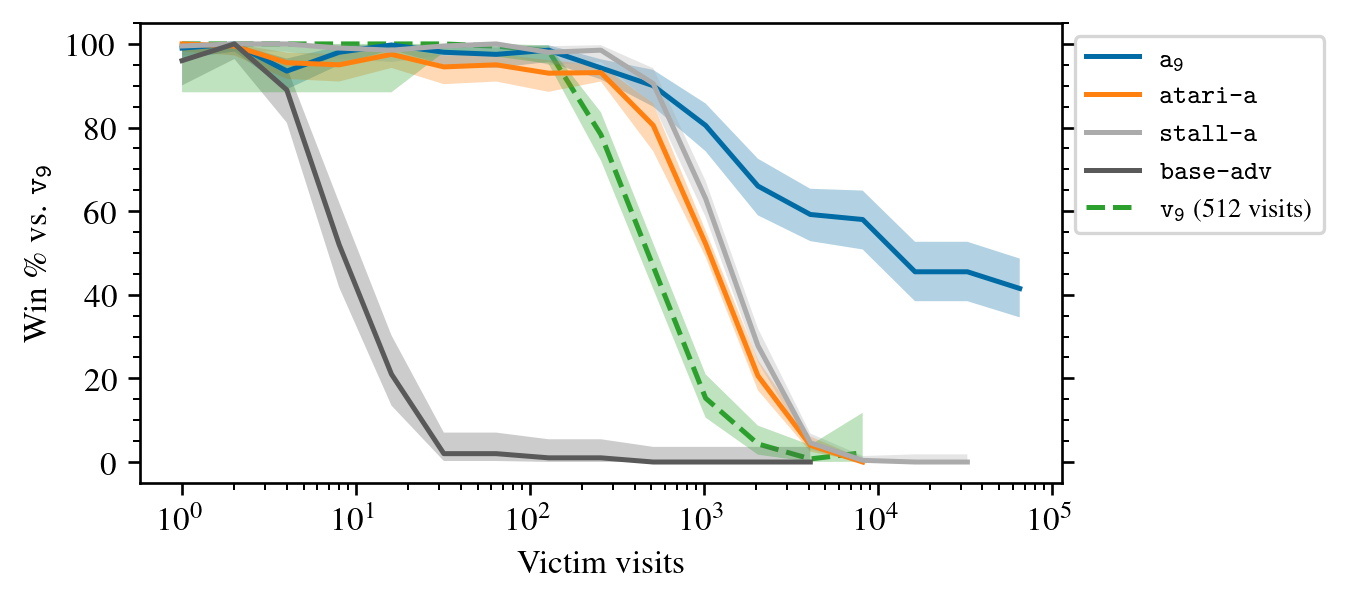

In [23]:
attack_h9_df = utils.parse_sgfs(["/shared/match/ttseng-attack-h9-240314/vs-h9"])
utils.parse_for_match(attack_h9_df, adv_name_regex="attack-h9")

stall_df = utils.parse_sgfs(["/shared/match/ttseng-attack-ft-h9-sweeps-240715/vary-victim-visits"])
utils.parse_for_match(stall_df, adv_name_regex="attack-ft-h9")

r9_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/r9-vs-h9"])
# Only get games against h9
r9_df = filter_df_for_player(r9_df, "h9")
utils.parse_for_match(r9_df, adv_name_regex="r9")


original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-1"])
# Only get games against h9
original_cyclic_df = filter_df_for_player(original_cyclic_df, "h9")
utils.parse_for_match(original_cyclic_df, adv_name_regex="r0-v600")

fig, ax = plot_victim_visit_sweep(
    [
        (r9_df, r"\attackiter{9}"),
        (attack_h9_df, r"\attackhnineshort{}"),
        (stall_df, r"\stalladvshort{}"),
        (original_cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\defenseiter{9}",
)

m, l, h = get_adv_win_grouped_by_victim_visits(h9_df)
m.plot(
    ax=ax,
    label=rf"\defenseiter{{9}} ({TARGET_VISITS} visits)",
    linestyle="--",
    color="tab:green",
    zorder=-10,
)
ax.fill_between(m.index, l, h, alpha=0.3, facecolor="tab:green")
plt.xlabel("Victim visits")

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.savefig("icr-h9.pgf", backend="pgf")

### b18

In [24]:
b18_df_raw = utils.parse_sgfs(["/shared/match/paper-robustness/elo/inference-compute-robustness/b18-s8527m"] +
    [f"/shared/match/paper-robustness/elo/b18/b18-s8527m/{i}" for i in range(3)]
).query(
    'b_name.str.contains("b18-s8527m") and w_name.str.contains("b18-s8527m")'
)

print(len(b18_df_raw))
b18_df_raw.head(1)

3776


,b_name,w_name,b_visits,w_visits,victim_color,victim_name,victim_visits,victim_steps,victim_rsym,victim_algo,...,has_button,whb,fpok,init_turn_num,used_initial_position,gtype,is_continuation,is_resignation,sgf_path,sgf_line
0,b18-s8527m-v128,b18-s8527m-v512,128,512,None,None,1,None,None,None,...,False,0,False,0,False,normal,False,False,/shared/match/paper-robustness/elo/inference-c...,1


In [25]:
b18_df = get_visit_games(b18_df_raw)

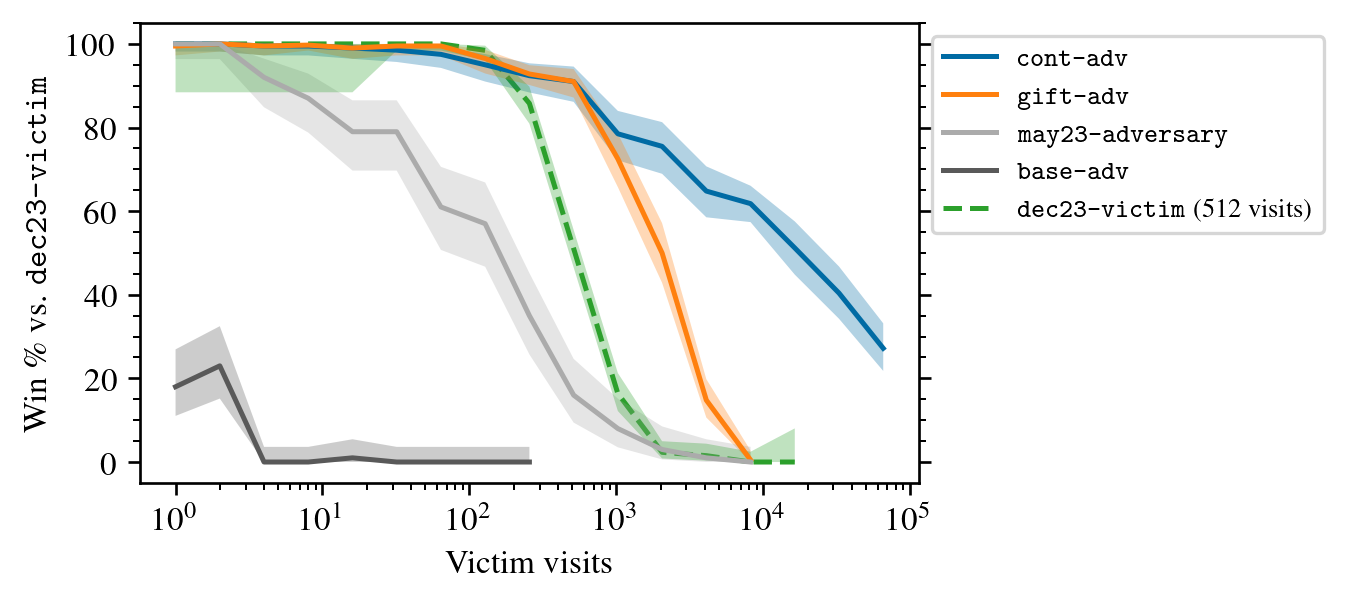

In [26]:
cont_df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-upto-v4096",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v8192-and-b60",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v16k-to-65k",
    ]
)
cont_df = filter_df_for_player(cont_df, "b18")
utils.parse_for_match(cont_df, adv_name_regex="cont")

ko_df = utils.parse_sgfs(["/shared/match/ttseng-attack-b18-240417/victim-visits"])
utils.parse_for_match(ko_df, adv_name_regex="attack-b18")

cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-cont-vs-b18-s8527m-240311/cyclic"])
utils.parse_for_match(cyclic_df, adv_name_regex="r0-v600")

attack_b60_df = utils.parse_sgfs(
    ["/shared/match/ttseng-cont-vs-b18-s8527m-240311/attack-b60"]
)
utils.parse_for_match(attack_b60_df, adv_name_regex="attack-b60")

fig, ax = plot_victim_visit_sweep(
    [
        (cont_df, r"\contadvmedium{}"),
        (ko_df, r"\koadvmedium{}"),
        (attack_b60_df, r"\attackbsixty{}"),
        (cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\dectwentythree{}",
)

m, l, h = get_adv_win_grouped_by_victim_visits(b18_df)
m.plot(
    ax=ax,
    label=rf"\dectwentythree{{}} ({TARGET_VISITS} visits)",
    linestyle="--",
    color="tab:green",
    zorder=-10,
)
ax.fill_between(m.index, l, h, alpha=0.3, facecolor="tab:green")
plt.xlabel("Victim visits")

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.savefig("icr-b18.pgf", backend="pgf")

In [27]:
b18_df_raw = utils.parse_sgfs(["/shared/match/paper-robustness/elo/b18/b18-s9997m", "/shared/match/paper-robustness/elo/inference-compute-robustness/b18-s9997m"]).query(
    'b_name.str.contains("b18-s9997m") and w_name.str.contains("b18-s9997m")'
)

print(len(b18_df_raw))
b18_df_raw.head(1)

3531


,b_name,w_name,b_visits,w_visits,victim_color,victim_name,victim_visits,victim_steps,victim_rsym,victim_algo,...,has_button,whb,fpok,init_turn_num,used_initial_position,gtype,is_continuation,is_resignation,sgf_path,sgf_line
2,b18-s9997m-v1024,b18-s9997m-v128,1024,128,None,None,1,None,None,None,...,False,0,False,0,False,normal,False,False,/shared/match/paper-robustness/elo/b18/b18-s99...,3


In [28]:
b18_df = get_visit_games(b18_df_raw)

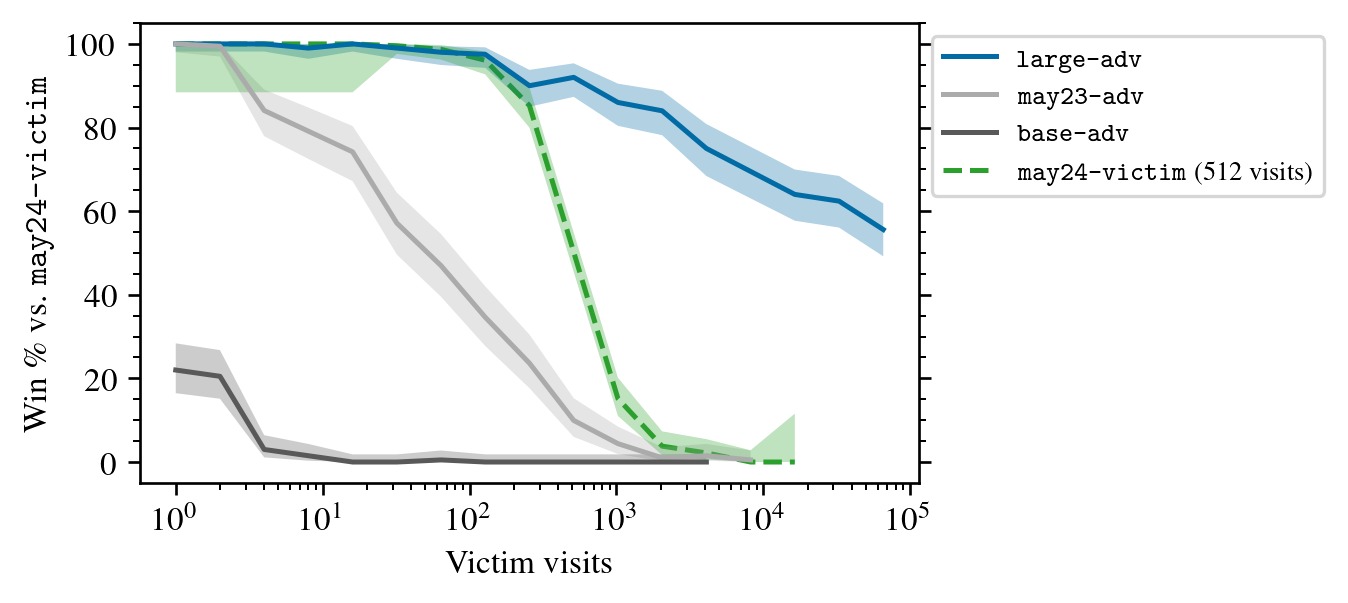

In [29]:
transfer_df = utils.parse_sgfs(["/shared/match/ttseng-large-adv-240715/b18-s9997m-transfer"])
# cont_df = filter_df_for_player(transfer_df, "cont-s630m")
# utils.parse_for_match(cont_df, adv_name_regex="cont-s630m")
# ko_df = filter_df_for_player(transfer_df, "attack-b18-s651m")
# utils.parse_for_match(ko_df, adv_name_regex="attack-b18-s651m")
attack_b60_df = filter_df_for_player(transfer_df, "attack-b60")
utils.parse_for_match(attack_b60_df, adv_name_regex="attack-b60")

large_df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-large-adv-240715/victim-visits/b18-s9997m/2",
        "/shared/match/ttseng-large-adv-240715/victim-visits/b18-s9997m/3",
    ]
)
utils.parse_for_match(large_df, adv_name_regex="large")

cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-large-adv-240715/orig-cyclic-vs-b18-s9997m"])
utils.parse_for_match(cyclic_df, adv_name_regex="r0-v600")

fig, ax = plot_victim_visit_sweep(
    [
        # (cont_df, r"\contadvmedium{}"),
        # (ko_df, r"\koadvmedium{}"),
        (large_df, r"\largeadvmedium{}"),
        (attack_b60_df, r"\attackbsixtymedium{}"),
        (cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\maytwentyfour{}",
)

m, l, h = get_adv_win_grouped_by_victim_visits(b18_df)
m.plot(
    ax=ax,
    label=rf"\maytwentyfour{{}} ({TARGET_VISITS} visits)",
    linestyle="--",
    color="tab:green",
    zorder=-10,
)
ax.fill_between(m.index, l, h, alpha=0.3, facecolor="tab:green")
plt.xlabel("Victim visits")

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.savefig("icr-b18-s9997m.pgf", backend="pgf")

### ViT

In [30]:
vit_df_raw = utils.parse_sgfs(["/shared/match/paper-robustness/elo/vit", "/shared/match/paper-robustness/elo/inference-compute-robustness/vit"]).query(
    'b_name.str.contains("vit-b16-s650025472")'
    ' and w_name.str.contains("vit-b16-s650025472")'
)

print(len(vit_df_raw))
vit_df_raw.head(1)

10180


,b_name,w_name,b_visits,w_visits,victim_color,victim_name,victim_visits,victim_steps,victim_rsym,victim_algo,...,has_button,whb,fpok,init_turn_num,used_initial_position,gtype,is_continuation,is_resignation,sgf_path,sgf_line
2,vit-b16-s650025472-v32768,vit-b16-s650025472-v32768,32768,32768,None,None,1,None,None,None,...,False,0,False,0,False,normal,False,False,/shared/match/paper-robustness/elo/vit/shared-...,3


In [31]:
vit_df = get_visit_games(vit_df_raw)

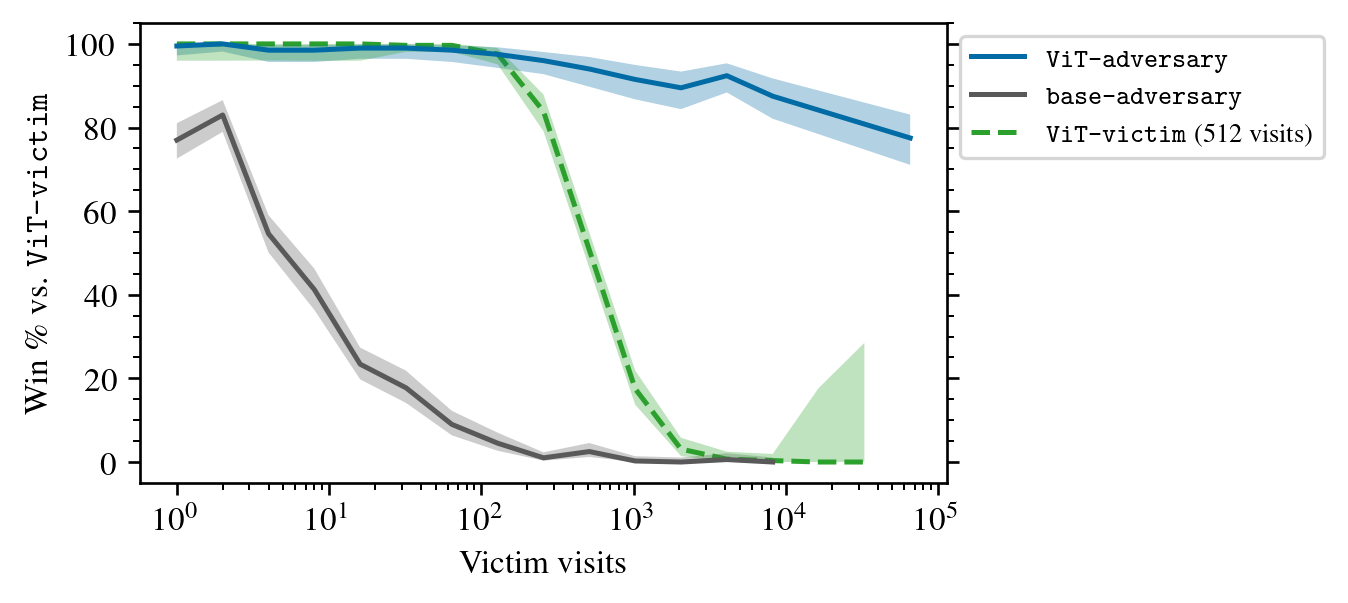

In [32]:
attack_vit_df = utils.parse_sgfs(
    ["/shared/match/ttseng-attack-vit-240311/v1-to-v8192-and-v65536"]
)
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-vitb16-vs-cyclic"])
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\vitadversary{}"),
        (original_cyclic_df, r"\origcyclic{}"),
    ],
    r"\vitvictim{}",
)

m, l, h = get_adv_win_grouped_by_victim_visits(vit_df)
m.plot(
    ax=ax,
    label=rf"\vitvictim{{}} ({TARGET_VISITS} visits)",
    linestyle="--",
    color="tab:green",
    zorder=-10,
)
ax.fill_between(m.index, l, h, alpha=0.3, facecolor="tab:green")
plt.xlabel("Victim visits")

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.savefig("icr-vit.pgf", backend="pgf")